In [44]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Algorithm BuildDecisionTree(Dataset D, FeatureList F)
#     if all examples in D are of the same class
#         return a leaf node with that class
#     else if F is empty
#         return a leaf node with the majority class in D
#     else
#         bestFeature = SelectFeatureWithHighestIG(D, F)
#         Tree = a new decision tree node for bestFeature
#         for each possible value v of bestFeature
#             Subset D_v = subset of D where bestFeature = v
#             if D_v is empty
#                 add a leaf node with the majority class in D to Tree
#             else
#                 subtree = BuildDecisionTree(D_v, F - {bestFeature})
#                 add subtree to Tree under branch corresponding to v
#         return Tree


# Algorithm BuildRandomForest(Dataset D, NumberOfTrees, FeaturesPerSplit)
#     Forest = []
#     for i = 1 to NumberOfTrees
#         BootstrapSample = RandomSampleWithReplacement(D)
#         Tree = BuildRandomDecisionTree(BootstrapSample, FeaturesPerSplit)
#         add Tree to Forest
#     return Forest

# Algorithm BuildRandomDecisionTree(Dataset D, FeaturesPerSplit)
#     if all examples in D are of the same class
#         return a leaf node with that class
#     else if FeaturesPerSplit is zero
#         return a leaf node with the majority class in D
#     else
#         RandomFeatures = RandomlySelectFeatures(D, FeaturesPerSplit)
#         bestFeature = SelectFeatureWithHighestIG(D, RandomFeatures)
#         Tree = a new decision tree node for bestFeature
#         for each possible value v of bestFeature
#             Subset D_v = subset of D where bestFeature = v
#             if D_v is empty
#                 add a leaf node with the majority class in D to Tree
#             else
#                 subtree = BuildRandomDecisionTree(D_v, FeaturesPerSplit)
#                 add subtree to Tree under branch corresponding to v
#         return Tree

# Function Predict(Forest, new_instance)
#     results = []
#     for Tree in Forest
#         result = PredictWithTree(Tree, new_instance)
#         add result to results
#     return MajorityVote(results)


In [46]:
c = input("Clean data? (Press Y/N)")

if c == "Y":
    flood = pd.read_csv('./flood.csv')
    # print all the columns
    flood.describe()

    for column in flood.columns:
        if flood[column].dtype in ["int64", "float64"]:
            q1 = flood[column].quantile(0.25)
            q3 = flood[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            flood = flood[(flood[column] >= lower_bound) & (flood[column] <= upper_bound)]


    # normalize the data except the target column

    flood_prob = flood['FloodProbability']

    flood = (flood - flood.mean()) / flood.std()

    flood['FloodProbability'] = flood_prob 
    flood.to_csv('./cleaned_flood.csv', index=False)

In [47]:
flood = pd.read_csv('./cleaned_flood.csv')


# print all the columns
print(flood.columns)

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')


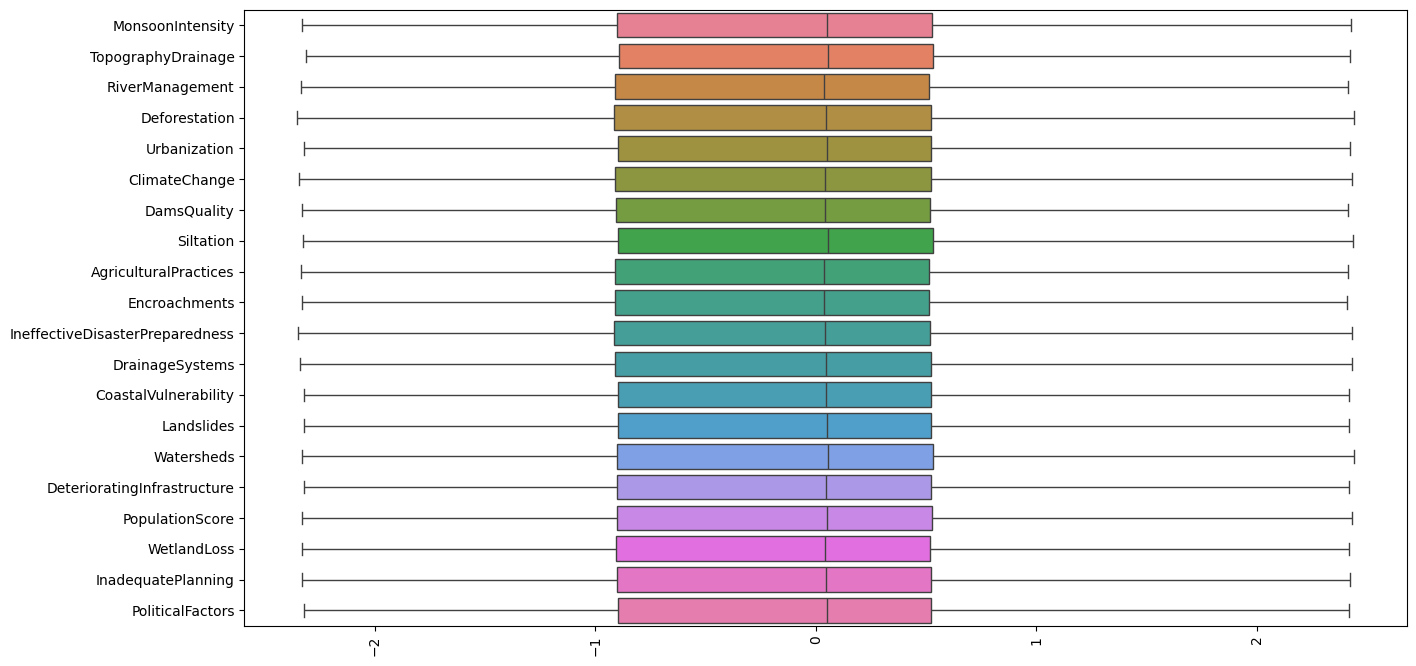

In [48]:
# Check Data After Removing Outlier
plt.figure(figsize=(15,8))
# all except the last column
sns.boxplot(data=flood.iloc[:, :-1], orient="h")
plt.xticks(rotation=90)
plt.show()

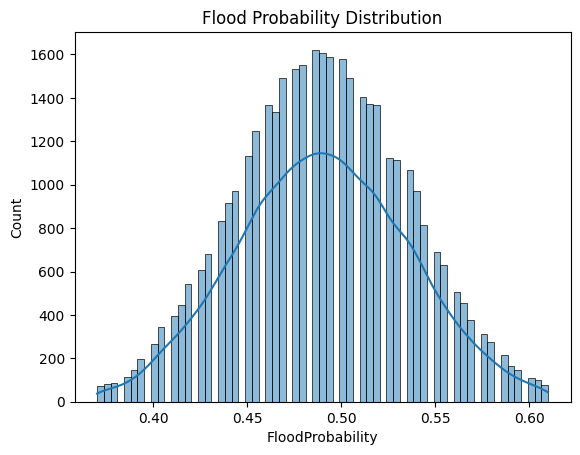

In [49]:
sns.histplot(x=flood['FloodProbability'], data=flood, kde=True)
plt.title("Flood Probability Distribution")
plt.show()

Text(0.5, 1.0, 'Correlation with Flood Probability')

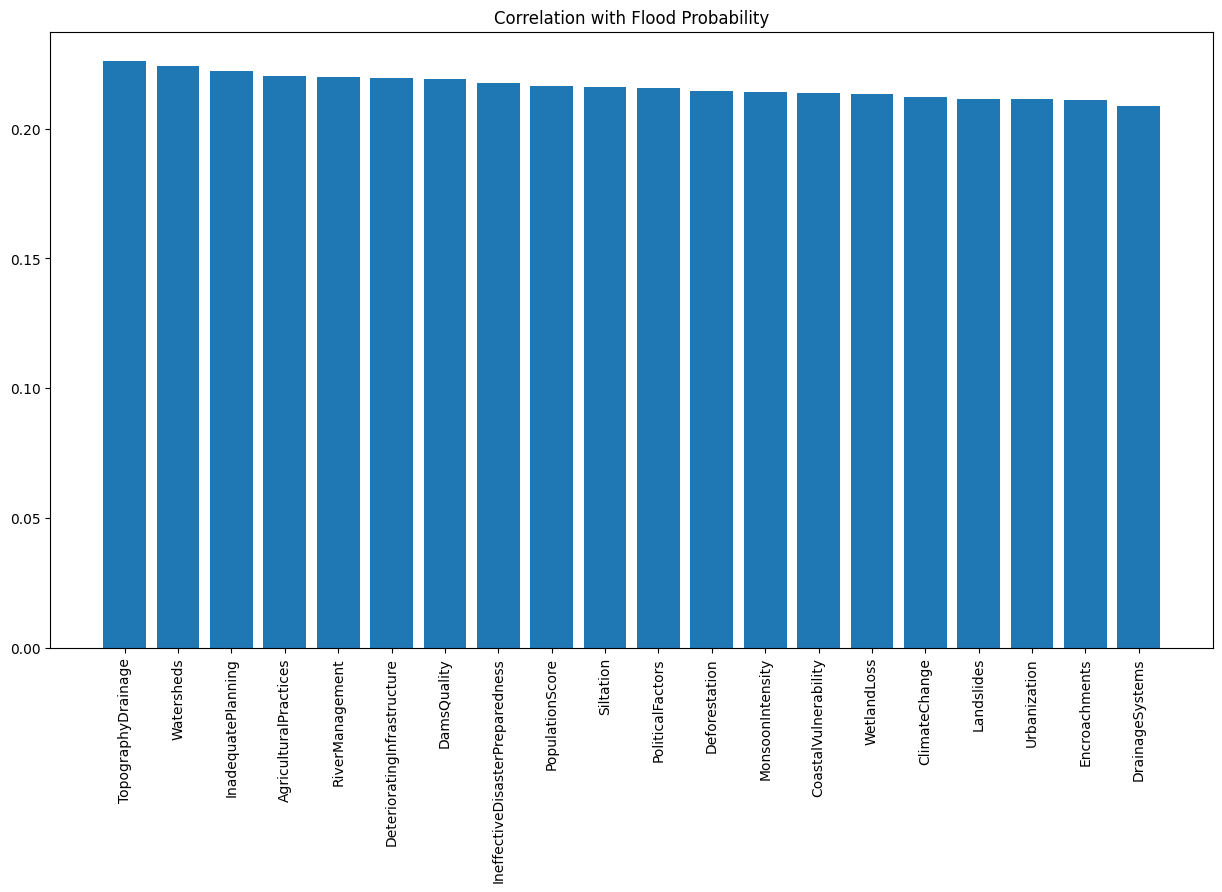

In [50]:
# plot correlation with each column, plot sorted by correlation
correlation = [np.abs(flood[column].corr(flood['FloodProbability'])) for column in flood.columns[:-1]]

# convert the Index to a list
columns = list(flood.columns[:-1])

# sort the correlation
correlation, columns = zip(*sorted(zip(correlation, columns), reverse=True))

plt.figure(figsize=(15,8))
plt.bar(columns, correlation)
plt.xticks(rotation=90)
plt.title("Correlation with Flood Probability")

In [51]:

X = flood.drop('FloodProbability', axis=1) 
y = flood['FloodProbability']

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
from sklearn.ensemble import RandomForestRegressor
import joblib

c = input("Train Random Forest Model? (Press Y/N)")

if c == "Y":
    rf = RandomForestRegressor()

    rf.fit(X_train, y_train)

    joblib.dump(rf, 'flood_model_rf.pkl')


In [54]:
rf = joblib.load('flood_model_rf.pkl')

R2 Score : 0.7177988882875421
Mean Squared Error : 0.0005859346462180402
Root Mean Squared Error : 0.02420608696625789


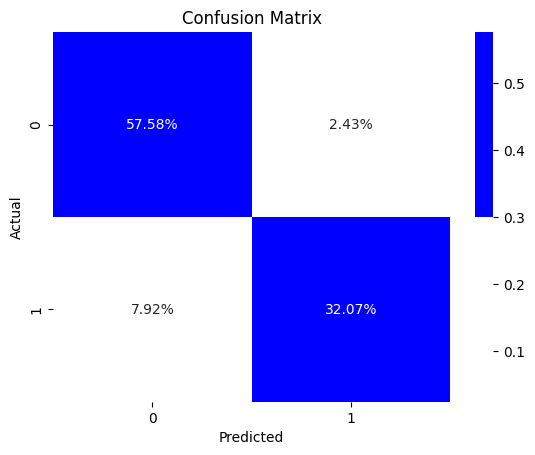

In [55]:
y_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

print('R2 Score :', r2_score(y_test, y_pred))
print('Mean Squared Error :', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error :', np.sqrt(mean_squared_error(y_test, y_pred)))


# quantize in ones and zeros
y_pred_quantized = np.where(y_pred > 0.5, 1, 0)
y_test_quantized = np.where(y_test > 0.5, 1, 0)
total = len(y_test_quantized)
# plot confusion matrix normalized



cm = confusion_matrix(y_test_quantized, y_pred_quantized)
cm = cm / total

accuracy_rf = (cm[0][0] + cm[1][1])

sns.heatmap(cm, annot=True, fmt=".2%", cmap=['white','blue'], xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [56]:
from sklearn.tree import DecisionTreeRegressor

c = input("Train Decision Tree Model? (Press Y/N)")

if c == "Y":
    dt = DecisionTreeRegressor()

    dt.fit(X_train, y_train)

    joblib.dump(dt, 'flood_model_dt.pkl')

In [57]:
dt = joblib.load('flood_model_dt.pkl')

R2 Score : 0.10230854675922851
Mean Squared Error : 0.0018638782848011367
Root Mean Squared Error : 0.04317265667990721


Text(0.5, 1.0, 'Confusion Matrix')

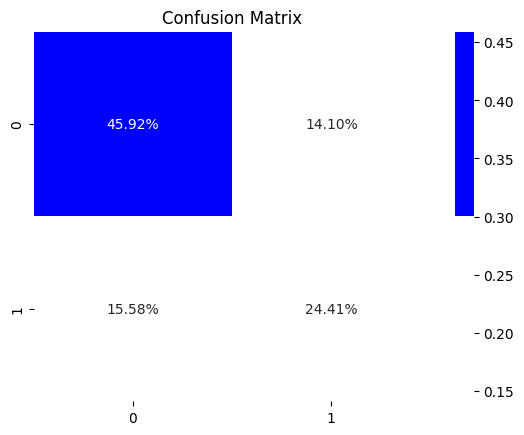

In [58]:
y_pred = dt.predict(X_test)

print('R2 Score :', r2_score(y_test, y_pred))
print('Mean Squared Error :', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error :', np.sqrt(mean_squared_error(y_test, y_pred)))

# quantize in ones and zeros
y_pred_quantized = np.where(y_pred > 0.5, 1, 0)
y_test_quantized = np.where(y_test > 0.5, 1, 0)

# plot confusion matrix normalized
cm = confusion_matrix(y_test_quantized, y_pred_quantized)
cm = cm / total

accuracy_dt = (cm[0][0] + cm[1][1])

sns.heatmap(cm, annot=True, fmt=".2%", cmap=['white','blue'], xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title("Confusion Matrix")

In [59]:
from sklearn.linear_model import LinearRegression

c = input("Train Linear Regression Model? (Press Y/N)")

if c == "Y":
    linreg = LinearRegression()

    linreg.fit(X_train, y_train)

    joblib.dump(linreg, 'flood_model_linreg.pkl')

In [60]:
linreg = joblib.load('flood_model_linreg.pkl')

R2 Score : 1.0
Mean Squared Error : 2.1131445606005824e-31
Root Mean Squared Error : 4.596895213729135e-16


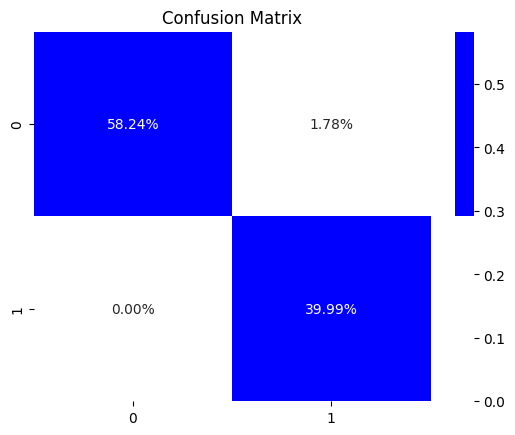

In [61]:
y_pred = linreg.predict(X_test)

print('R2 Score :', r2_score(y_test, y_pred))
print('Mean Squared Error :', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error :', np.sqrt(mean_squared_error(y_test, y_pred)))

# quantize in ones and zeros
y_pred_quantized = np.where(y_pred > 0.5, 1, 0)
y_test_quantized = np.where(y_test > 0.5, 1, 0)

# plot confusion matrix normalized

cm = confusion_matrix(y_test_quantized, y_pred_quantized)
cm = cm / total

accuracy_linreg = (cm[0][0] + cm[1][1]) 

sns.heatmap(cm, annot=True, fmt=".2%", cmap=['white','blue'], xticklabels=['0', '1'], yticklabels=['0', '1'])

plt.title("Confusion Matrix")
plt.show()

In [62]:


plt.figure(figsize=(15,8))

# print feature importance for Random Forest

for i, column in enumerate(X.columns):
    print(f'{column} : {rf.feature_importances_[i]}')

# plot the accuracy of the models using 

models = ['Random Forest', 'Decision Tree', 'Linear Regression']

accuracies = [accuracy_rf, accuracy_dt, accuracy_linreg]

# print table

for model, accuracy in zip(models, accuracies):
    print(f'{model} : {accuracy}')



MonsoonIntensity : 0.05008621614170485
TopographyDrainage : 0.05373028297708071
RiverManagement : 0.0498347625135576
Deforestation : 0.04780616520537346
Urbanization : 0.0464944174281895
ClimateChange : 0.05021264825557457
DamsQuality : 0.05185308399633689
Siltation : 0.04893900767113484
AgriculturalPractices : 0.04976019686848544
Encroachments : 0.050364926225188775
IneffectiveDisasterPreparedness : 0.0497119353688924
DrainageSystems : 0.046856757939900275
CoastalVulnerability : 0.05211028974718543
Landslides : 0.04981872102916664
Watersheds : 0.05132171361390472
DeterioratingInfrastructure : 0.05095595465397158
PopulationScore : 0.050917401594608364
WetlandLoss : 0.04838153161551773
InadequatePlanning : 0.04941903498498646
PoliticalFactors : 0.051424952169239854
Random Forest : 0.896484375
Decision Tree : 0.7032137784090909
Linear Regression : 0.9822443181818181


<Figure size 1500x800 with 0 Axes>